<a href="https://colab.research.google.com/github/monikamikhaiel/graduation-project-/blob/main/Multiple_Antennas_qtable_%2Bheat_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np  # for array stuff and random
import matplotlib.pyplot as plt  # for graphing our mean rewards over time
from matplotlib.pyplot import figure
from matplotlib import style  # to make pretty charts because it matters.
import time  # using this to keep track of our saved Q-Tables.
style.use("ggplot")  # setting our style!

In [2]:
#the size of the area 
SIZE_W = int(input("please enter the width of the building in meter :"))
SIZE_H = int(input("please enter the height of the building in meter :"))
print(SIZE_H,SIZE_W)

please enter the width of the building in meter :20
please enter the height of the building in meter :20
20 20


In [3]:
HM_EPISODES = 2500
epsilon = 0.5  # randomness
EPS_DECAY = 0.9999  # Every episode will be epsilon*EPS_DECAY
SHOW_EVERY = 100  # how often to play through env visually.

start_q_table = None  # if we have a pickled Q table, we'll put the filename of it here.

LEARNING_RATE = 0.1
DISCOUNT = 0.95
ANTENNA_N = int(input("please enter the number of antennas ?"))  # NUMBER OF ANTENNAS 
#SNR RANGES
snr_range={"highSNR_max":-50,"highSNR_min":-80,
           "mediumSNR_max":-90,"mediumSNR_min":-100,
          "deadzone":-120}


please enter the number of antennas ?4


In [4]:
#antenna
class antenna:
    def __init__(self,x_,y_):
      if not x_:
        self.x = np.random.randint(0, SIZE_W)
      else:
        self.x=x_
      if not y_:
        self.y = np.random.randint(0, SIZE_H)
      else:
        self.y=y_
    def __str__(self):
        return f"{self.x}, {self.y}"
    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)
    def action(self, choice):
        '''
        Gives us 4 total movement options. (0,1,2,3)
        '''
        if choice == 0:  #up
            #self.move(x=0, y=1)
            self.x=self.x
            self.y+=1
            self.move()

        elif choice == 1:  #down
            #self.move(x=0, y=-1)
            self.x=self.x
            self.y-=1
            self.move()

        elif choice == 2:  #left
           # self.move(x=-1, y=0)
            self.x-=1
            self.y=self.y
            self.move()

        elif choice == 3:    #right
            # self.move(x=1, y=0)
            self.x+=1
            self.y=self.y
            self.move()

#    def move(self, x=False, y=False):
    def move(self):
        # If no value for x, move randomly
      #  if not x:
      #      self.x += np.random.randint(-1, 2)
       # elif x==0:
      #      self.x=self.x
      #  else:
       #     self.x += x

        # If no value for y, move randomly
       # if not y:
        #    self.y += np.random.randint(-1, 2)
       # elif y==0:
        #    self.y=self.y
       # else:
        #    self.y += y
      # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE_W-1:
            self.x = SIZE_W-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE_H-1:
            self.y = SIZE_H-1



In [5]:
ant = antenna(2,3)
print(ant)
ant.action(0) # up
print(ant)
ant.action(1) #down 
print(ant)
ant.action(2) #left
print(ant)
ant.action(3) #right 
print(ant)


2, 3
2, 4
2, 3
1, 3
2, 3


In [6]:
x = SIZE_W # Building X
y = SIZE_H # Building Y
z = 4 # actions
## increase the size of a qtable dynamically from the number of antennas 
q_table={}
for i in range(ANTENNA_N):
  q_table[i]=np.zeros((x,y,z))
  print(q_table[i].shape)

#print(q_table)
# q_table *= 0

(20, 20, 4)
(20, 20, 4)
(20, 20, 4)
(20, 20, 4)


In [7]:
#okomora model 
def okomora(ant,SIZE_H,SIZE_W):
  PathLoss=[]
  attenuation= 13 #in db function of frequency and distance 
  freq= 2.4*(10^9) # the frequency og the signal
  c= 3*(10^8) # the speed of light
  #hte = input("please enter the height of the transmitter antenna ? ")
  #hre = input("please enter the height of the receiver antenna ? ")
  hte= 20
  hre= 2
  G_hte = 10*np.log(int(hte) /200) 
  G_hre = 10*np.log(int(hre)/ 3)
  G_Area =27 # (Quasi Open Area)
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference == [0,0]:
        continue
      else:
        ## calculate the pathloss
        distance=pow((pow(difference[0],2)+pow(difference[1],2)),0.5)
        FPL      = 20*np.log(4*np.pi*distance*freq/c)
        Path_Loss = FPL + attenuation - G_hte - G_hre - G_Area
        PathLoss.append(Path_Loss)
  return PathLoss  
#len(okomora(ant,SIZE_H,SIZE_W))

In [8]:
def AnglesInDegrees(ant,SIZE_H,SIZE_W):
  theta=[]
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      difference = [ant.x-i,ant.y-j]
      if difference==[0,0]: # the same position as the antenna 
        continue
      if difference[0]==0:     # the angle itself is either 90 or 270 tan will be infinite 
          if difference[1]>0:
            t=90
            theta.append(90)
          else:
            t=270
            theta.append(270)
      else:
          tantheta= difference[1]/difference[0]
          t=np.degrees(np.arctan(tantheta))
          if t <=0:
            t+=360
            theta.append(t)
          else:
            theta.append(t)
  return theta
#print(len(AnglesInDegrees(ant,SIZE_H,SIZE_W)))

In [9]:
def measureSNR(ant,SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel"):
  Path_Loss=okomora(ant,SIZE_H,SIZE_W)
  Gain=[]
  if typeOfAntenna == "omnidirectionnel" :
    Gain_pannel=7 #in db
    for i in range(len(Path_Loss)):
      Gain.append(Gain_pannel-Path_Loss[i])
  elif typeOfAntenna== "directionnel":
    thetas=AnglesInDegrees(ant,SIZE_H,SIZE_W)
    GainVsTheta={360:-20,30:-10,60:-5,90:15,120:0,150:-10,180:-20,210:-10,240:-8,270:-15,300:-8,330:-10} # values in db angle:gain
    for i in range(len(thetas)):
      t=thetas[i]
      if t==0:
       value = GainVsTheta[360]
      elif t<=30:
        value = GainVsTheta[30]
      elif 30<t<=60:
        value = GainVsTheta[60]
      elif 60<t<=90:
        value = GainVsTheta[90]
      elif 90<t<=120:
        value = GainVsTheta[120]
      elif 120<t<=150:
        value = GainVsTheta[150]
      elif 150<t<=180:
        value = GainVsTheta[180]
      elif 180<t<=210:
        value = GainVsTheta[210]
      elif 210<t<=240:
        value = GainVsTheta[240]
      elif 240<t<=270:
        value = GainVsTheta[270]
      elif 270<t<=300:
        value = GainVsTheta[300]
      elif 300<t<=330:
        value = GainVsTheta[330]
      elif 330<t<=360:
        value = GainVsTheta[360]
      Gain.append(value-Path_Loss[i])
  Magnitude=[]
  for g in Gain:
    mag=pow(10,(g/10))
    Magnitude.append(mag)
  return Gain #return in db to add the snr values 
ant=antenna(2,3)
measureSNR(ant,SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel")


[-85.99691166090237,
 -81.14183350308535,
 -76.441797210628,
 -74.21036169748591,
 -76.441797210628,
 -81.14183350308535,
 -85.99691166090237,
 -90.30474082182691,
 -94.02037638615172,
 -97.23621262742637,
 -100.0503372218082,
 -102.54249513804808,
 -104.77393065119014,
 -106.79132707770071,
 -108.63055545931002,
 -110.31954082392815,
 -111.8803340312648,
 -113.33059175176737,
 -114.68463812182938,
 -115.9542343964423,
 -83.37326901622747,
 -76.441797210628,
 -67.27888989188646,
 -60.34741808628699,
 -67.27888989188646,
 -76.441797210628,
 -83.37326901622747,
 -88.67955152684915,
 -92.92838346650181,
 -96.45659721272926,
 -99.46764814056843,
 -102.09129078524336,
 -104.41461055892955,
 -106.49862325469962,
 -108.38762853361959,
 -110.11475551049273,
 -111.70540245678961,
 -113.17945537366688,
 -114.55276807900987,
 -115.83817893523923,
 -82.3196638596492,
 -74.21036169748591,
 -60.34741808628699,
 -60.34741808628699,
 -74.21036169748591,
 -82.3196638596492,
 -88.0733053086848,
 -92.536

In [10]:
def calSNRlow(SNR,TypeOfReward):
  if TypeOfReward=="AverageSNR":
   return np.mean(SNR)
  else:
    counter =0
    min= 5.095204897841283e-9
    for i in range(len(SNR)):
      if SNR[i] < min:
        counter+=1
        percent=counter*100/len(SNR)
    return percent
ant=antenna(2,3)
calSNRlow(measureSNR (ant,SIZE_H,SIZE_W),TypeOfReward="AverageSNR")

-106.54854504403419

In [11]:
def differnceXandY(ant1,ant2):
  diff_X= ant1.x-ant2.x
  diff_Y= ant1.y-ant2.y
  return diff_X,diff_Y

In [12]:
def RewardCalc(antennas_object,ANTENNA_N,typeOfAntenna="omnidirectionnel",TypeOfReward="AverageSNR"):
  mini_distance_X= 1
  mini_distance_Y= 1   
  antennas_meanSNR={} # antenna and their mean values
  #antennas_object={} # antenna and their classes
  reward=0
  for i in range(ANTENNA_N):
    #antennas_object[i]=antenna()
    antennas_meanSNR[i]=calSNRlow(measureSNR(antennas_object[i],SIZE_H,SIZE_W,typeOfAntenna=typeOfAntenna),TypeOfReward=TypeOfReward)
  #print(antennas_object)
  #print(antennas)
    reward+=antennas_meanSNR[i]
  reward/=ANTENNA_N
  #calculate the difference between each 2 antennas  
  for i in range(ANTENNA_N):
    for j in range(i):
      if i==j:
        continue
      else:
        #print(i,j)
        x,y=differnceXandY(antennas_object[i],antennas_object[j]) 
        if (x <= mini_distance_X) & (y <= mini_distance_Y):
          reward*=0 
        if reward==0:
          break
#convert from db into magnitude 
    mag=pow(10,(reward/10))
  return mag  
antennas_object={}
for i in range(ANTENNA_N):
  antennas_object[i]=antenna(2+i,3+i)
  #print( antennas_object[i].x, antennas_object[i].y)

RewardCalc(antennas_object,ANTENNA_N)

1.0

In [13]:
def TrainingAgent(HM_EPISODES=HM_EPISODES,EPS_DECAY=EPS_DECAY,LEARNING_RATE=LEARNING_RATE,DISCOUNT=DISCOUNT,epsilon=epsilon,
                  ANTENNA_N=ANTENNA_N,SIZE_H=SIZE_H,SIZE_W=SIZE_W,typeOfAntenna="omnidirectionnel",TypeOfReward="AverageSNR"):
## actions
  actions={}
## antennas object
  antennas_object={} # antenna and their classes
##
  episode_rewards = []
  reward=0
  for episode in range(HM_EPISODES):
      x_=np.random.randint(0, SIZE_H)
      y_=np.random.randint(0, SIZE_W)
      for i in range(ANTENNA_N):
        antennas_object[i]=antenna(x_,y_)
      if episode % SHOW_EVERY == 0:
          print(f"on #{episode}")
       # print(f"{SHOW_EVERY} ep mean: {np.mean(episode_rewards[-SHOW_EVERY:])}")
          show = True
      else:
          show = False

      episode_reward = 0
      for i in range(200):
        if np.random.random() > epsilon:
          for i in range(ANTENNA_N):
            actions[i] = np.argmax(q_table[i][antennas_object[i].x][antennas_object[i].y]) # antenna 1
        else:
          for i in range(ANTENNA_N):
            actions[i] = np.random.randint(0, 4) #low is inclusive high is exclusive
            #print(action)
        # Take the action!
        for i in range(ANTENNA_N):
          antennas_object[i].action(actions[i]) #move the  antenna
        ###
        #calculate the SNR
        reward=RewardCalc(antennas_object,ANTENNA_N,typeOfAntenna=typeOfAntenna,TypeOfReward=TypeOfReward)
          ###
        #current_q = q_table[state][action]
        #antena 1
        for i in range(ANTENNA_N):
            newAntennaPos = (ant)
            current_q = q_table[i][antennas_object[i].x][antennas_object[i].y][actions[i]] # Current State
            max_future_q = np.max(q_table[i][antennas_object[i].x][antennas_object[i].y]) # Max State
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[i][antennas_object[i].x][antennas_object[i].y][actions[i]] = new_q


        episode_reward += reward

        #print(episode_reward)
      episode_rewards.append(episode_reward)
      epsilon *= EPS_DECAY 
  return q_table

In [14]:
q_table=TrainingAgent(HM_EPISODES=HM_EPISODES,EPS_DECAY=EPS_DECAY,LEARNING_RATE=LEARNING_RATE,DISCOUNT=DISCOUNT,epsilon=epsilon,
                  ANTENNA_N=ANTENNA_N,SIZE_H=SIZE_H,SIZE_W=SIZE_W,typeOfAntenna="omnidirectionnel",TypeOfReward="AverageSNR")

on #0
on #100
on #200
on #300
on #400
on #500
on #600
on #700
on #800
on #900
on #1000
on #1100
on #1200
on #1300
on #1400
on #1500
on #1600
on #1700
on #1800
on #1900
on #2000
on #2100
on #2200
on #2300
on #2400


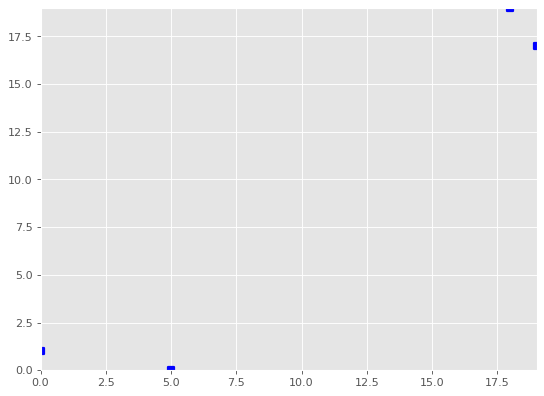

[19] [17]
[18] [19]
[0] [1]
[5] [0]
{0: [19, 17], 1: [18, 19], 2: [0, 1], 3: [5, 0]}


In [15]:
xval_={}
yval_={}
for n in range(ANTENNA_N):
  max_value =np.max((q_table[n]))
#print(max_value)
  for i in range(SIZE_H):
    for j in range(SIZE_W):
      for k in range(4):
        if max_value == (q_table[n][i][j][k]):
          xval_[n]=[i]
          yval_[n]=[j]
        else :
          continue
#outputOfTraining(q_table)
figure(figsize=(8, 6), dpi=80) # increase figure size 
for n in range(ANTENNA_N):
  plt.scatter(xval_[n], yval_[n], color= "blue", linewidths =2 ,marker ="s")
plt.xlim(0, SIZE_H-1)
plt.ylim(0, SIZE_W-1)
plt.show()
antennas_object_toplot_heat={}
for n in range(ANTENNA_N):
  print(xval_[n],yval_[n])
  antennas_object_toplot_heat[n]=[xval_[n][0],yval_[n][0]]
print(antennas_object_toplot_heat)


Average SNR must be constant 

assume that power adds up (SNR) -> reward 
qtable -> add the positions of new antenna and actions 
3 antennas optimization all area 


In [16]:
antennas_object_heatmap={} #dict for antennas and their position 
SumOfSNR=np.zeros((1,SIZE_H*SIZE_W))
position=[]
for n in range(ANTENNA_N):
  x=antennas_object_toplot_heat[n][0]
  y=antennas_object_toplot_heat[n][1]
  antennas_object_heatmap[n]=antenna(x,y)
  #1d coordinate 
  position.append((SIZE_H*x)+ y)
  ArrayOfSNR=measureSNR(antennas_object_heatmap[n],SIZE_H,SIZE_W,typeOfAntenna="omnidirectionnel")
  ArrayOfSNR=np.insert(ArrayOfSNR,position[n],0)
  SumOfSNR=np.add(SumOfSNR,ArrayOfSNR)
for i in range(len(SumOfSNR)):
  SumOfSNR[i]/=ANTENNA_N #average 
print(len(SumOfSNR[0])) 

400


In [17]:
import pandas as pd
import seaborn as sns
# sns.set()
snr_db=SumOfSNR
#for SNR in (SumOfSNR):
#  out_=10*np.log10(SNR)
#  snr_db.append(out_)
#print(snr_db)
# Build data
max_value_snr=np.max(snr_db)
min_value_snr=np.min(snr_db)
print(max_value_snr)
print(min_value_snr)

-77.13319054549669
-120.10430884005633


1


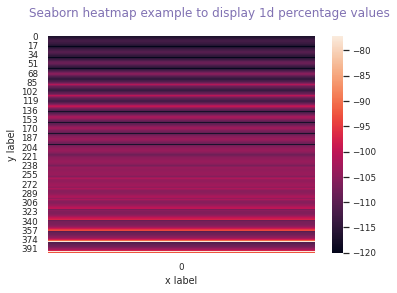

In [18]:
## 1D heatmap
plt.figure()
plt.suptitle("Seaborn heatmap example to display 1d percentage values", color='m')
sns.set(font_scale=0.8)

print(len(snr_db))
snr_db=np.reshape(snr_db,((SIZE_H*SIZE_W),1)) ## size_w*size_h -1
ax = sns.heatmap(snr_db, vmin=min_value_snr, vmax=max_value_snr)
ax.set(xlabel='x label', ylabel='y label')

plt.show()

In [19]:
#create 2D heatmap
rows=[]
#print(type(snr_db[0]))
# insert a value
#convert 2d array 
snr_db=np.reshape(snr_db,(SIZE_H,SIZE_W))
#print(snr_db)
for n in range(ANTENNA_N):
  x=antennas_object_toplot_heat[n][0]
  y=antennas_object_toplot_heat[n][1]
  snr_db[x][y]=0
#print(snr_db)
rows=snr_db
print(rows) 


[[-118.14218975    0.         -116.74350747 -116.0295735  -115.32283478
  -114.63096865 -113.96894716 -113.363392   -112.8559615  -112.50036152
  -112.34642229 -112.41505725 -112.68509577 -113.10644688 -113.62514962
  -114.19932641 -114.8022241  -115.41889182 -116.04188795 -116.66799022]
 [-120.10430884 -116.57717422 -115.79641224 -115.00941887 -114.21558747
  -113.4173501  -112.62500607 -111.865431   -111.19438429 -110.70315081
  -110.49418959 -110.61553396 -111.01882176 -111.60123696 -112.27110451
  -112.97227645 -113.67756744 -114.37655385 -115.06697286 -115.74996923]
 [-119.53816796 -115.69831136 -114.85562259 -113.99654376 -113.11394613
  -112.20046397 -111.25315801 -110.285704   -109.35655409 -108.61410326
  -108.29214679 -108.52449727 -109.17697395 -110.01533599 -110.89062924
  -111.74376406 -112.56046523 -113.34328802 -114.09962058 -114.83716172]
 [-119.01483003 -114.83015651 -113.93089005 -113.00707411 -112.04374294
  -111.01973724 -109.90819133 -108.68312647 -107.35294072 -10

<Figure size 432x288 with 0 Axes>

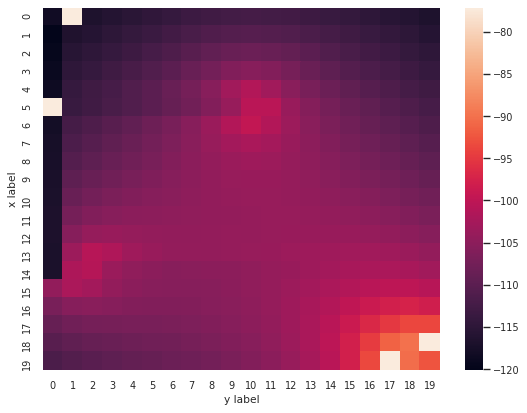

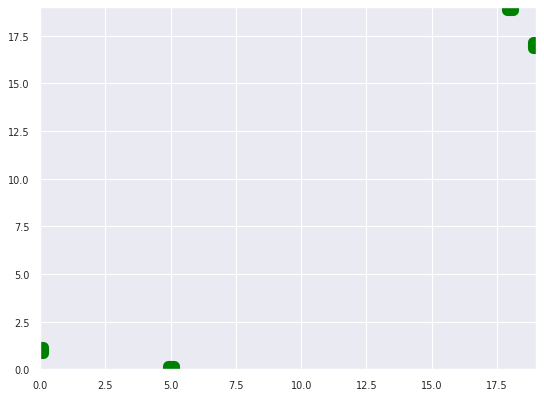

In [20]:
#2D heatmap
plt.figure()
plt.suptitle("Seaborn heatmap example to display 2d percentage values", color='m')
sns.set(font_scale=0.8)

#print(type(rows))
figure(figsize=(8, 6), dpi=80) # increase figure size 
rows_db=np.reshape(rows,(SIZE_H,SIZE_W))
ax = sns.heatmap(rows_db, vmin=min_value_snr, vmax=max_value_snr)
ax.set(xlabel='y label', ylabel='x label')


plt.show()
figure(figsize=(8, 6), dpi=80) # increase figure size 
for n in range(ANTENNA_N):
  plt.scatter(xval_[n], yval_[n], color= "green", linewidths =10 ,marker ="s")
plt.xlim(0, SIZE_H-1)
plt.ylim(0, SIZE_W-1)
plt.show()